In [23]:
data_type = 'red_data' # reduced data

In [24]:
n_bins = 10

In [25]:
import sys
sys.path.insert(0, '../..')
from definition import (
    data_names,
    limits_m_Kpipi,
    columns,
    column_ranges
)

MC_name   = data_names['MC']
data_name = data_names[data_type]
weight_MC_name = data_names['weight_MC']


low_m_Kpipi = limits_m_Kpipi[data_type]['low']
high_m_Kpipi = limits_m_Kpipi[data_type]['high']

print("MC name: ", MC_name)
print("data name: ", data_name)
print('----')
print('m_Kpipi')
print("low: ", low_m_Kpipi)
print("high: ", high_m_Kpipi)
print('----')
print("Range of the columns")
print(column_ranges)

MC name:  BTODstDX_MC
data name:  BTODstDX_reduced
----
m_Kpipi
low:  1820
high:  1950
----
Range of the columns
{'q2_reco': [2.0, None], 'isolation_bdt': [None, 0.95], 'tau_life_reco': [None, 0.003], 'B0_M': [3150, None], 'm_DstKpipi': [None, 5450]}


The columns that need to be looked at are:
- $q^2$: `q2_reco`
- *isolation BDT*: `isolation_bdt`
- $t_\tau$: `tau_life_reco`
- $m(D^*K\pi\pi)$: `m_DstKpipi`
- The angles 
    - $\theta_X$ ($=\theta_D$ of the paper?): `theta_X_reco`
    - $\theta_L$: `theta_L_reco`
    - $\chi$: `chi_reco`

# Check of the reweighting MC sample of $B \to D^{*-}\left(D^{+} \to K^- \pi^+ \pi^+  \right)X$ Background

In [26]:
# python libraries
import numpy as np
import zfit
import timeit
from scipy.stats import ks_2samp
import joblib
import pandas as pd

# bd2dsttaunu
from bd2dsttaunu.locations import loc

# HEA library
from HEA.plot import (
    plot_hist_auto, plot_hist, 
    save_fig, 
    plot_divide_auto,
    plot_hist_var,
)
from HEA import load_dataframe
from HEA.plot.tools import draw_vline
from HEA.definition import latex_params
from HEA.pandas_root import load_saved_root
from HEA.tools import get_chi2_2samp
from HEA.tools.string import str_number_into_latex

## Read the dataframe

In [62]:
df = {}

df['MC'] = load_saved_root(weight_MC_name, folder_name=MC_name)
df['data'] = load_saved_root(data_name + '_with_sWeights', folder_name=data_name)

Loading /home/correiaa/bd2dsttaunu/output//root/BTODstDX_MC/BTODstDX_MC_weights.root
Loading /home/correiaa/bd2dsttaunu/output//root/BTODstDX_reduced/BTODstDX_reduced_with_sWeights.root


In [63]:
len_data = len(df['data'])
print(len_data)

98638


In [64]:
df['data'] = df['data'].dropna()
df['MC'] = df['MC'].dropna()

In [65]:
print((len_data - len(df['data']))/len_data)

0.026541495164135526


In [29]:
plot_columns = [
    'costheta_X_reco', 
    'costheta_L_reco', 
    'chi_reco', 
    'isolation_bdt', 
    'q2_reco', 
    'B0_M',
#     'm_DstKpipi',
    'tau_M',
    'tau_life_reco'
]

## Get the $\chi^2$ distance between two the sWeighted LHCb data and reweighted or not MC
We define:
$$\chi^2 = \frac{1}{n_{bins}} \sum_{\text{bin i}} \frac{ \left(\frac{\#1[i]}{\#1} - \frac{\#2[i]}{\#2}\right)^2}{\frac{\#1[i]}{(\#1)^2} + \frac{\#2[i]}{(\#2)^2} }$$

In our case:
$$\chi^2 = \frac{1}{n_{bins}} \sum_{\text{bin i}} \frac{ \left(\frac{\text{#MC}[i]}{\text{#MC}} - \frac{\text{#data}[i]}{\text{#data}}\right)^2}{\frac{\text{#MC}[i]}{(\text{#MC})^2} + \frac{\text{#data}[i]}{(\text{#data})^2} }$$

In [30]:
def get_score(score_function, original_MC, 
              data, MC_weights, data_weights, 
              columns, column_ranges=None, 
              none_MC_weights=None,
              **params):
    """
    
    Parameters
    ----------
    """
    result_scores_dict = {}
    
    for column in columns:
        
        column_scores_dict = {}
        
        if column_ranges is not None:
            if column in column_ranges:
                low, high = column_ranges[column]
            else:
                low = None
                high = None
            
            params['low'] = low
            params['high'] = high
        
        column_scores_dict['original'] = score_function(
            original_MC[column], data[column],
            weights1=none_MC_weights, weights2=data_weights,
            **params # n_bins 
        )
        column_scores_dict['reweighted_MC'] = \
            score_function(original_MC[column], data[column], 
                           weights1=MC_weights, 
                           weights2=data_weights,
                           **params)
        
        result_scores_dict[column] = pd.Series(column_scores_dict.values(), 
                                               index=column_scores_dict.keys())
    
    result_scores_df = pd.DataFrame(result_scores_dict)
    
    return result_scores_df

In [31]:
true_data_weights = df['data']['sWeight']

result_chi2 = get_score(get_chi2_2samp,
                        original_MC=df['MC'].drop('weight', 1),
                        data=df['data'].drop('sWeight', 1),
                        MC_weights=df['MC']['weight'],
                        data_weights=df['data']['sWeight'],
                        columns=plot_columns,
                        column_ranges=column_ranges,
                        n_bins=n_bins,
                       )
                        

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(result_chi2)

               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              3.463967         5.335261  1.563659      15.768406   
reweighted_MC         1.747356         4.068748  1.194507       3.375186   

                 q2_reco       B0_M      tau_M  tau_life_reco  
original       47.686377  33.689255  94.671381       2.040593  
reweighted_MC   3.518580   4.030281  62.528929       1.918799  


## NEW




#### With `max_depth = 2`,  `learning_rate = 0.1` and `n_estimators = 35` 

```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              3.629092         5.346152  1.454718      15.190809   
reweighted_MC         1.795455         3.703425  2.024838       1.013369   

                 q2_reco       B0_M      tau_M  tau_life_reco  
original       46.213866  34.650520  95.561939       2.147196  
reweighted_MC   7.737062   2.539272  66.008241       2.128207  
 
```

#### With `max_depth = 2`,  `learning_rate = 0.1` and `n_estimators = 40` BETTER
```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              3.629092         5.346152  1.454718      15.190809   
reweighted_MC         1.630907         3.650310  2.155172       0.868883   

                 q2_reco       B0_M      tau_M  tau_life_reco  
original       46.213866  34.650520  95.561939       2.147196  
reweighted_MC   7.466881   2.350291  65.050147       2.159802  
```

#### With `max_depth = 2`,  `learning_rate = 0.1` and `n_estimators = 45` 
```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              3.629092         5.346152  1.454718      15.190809   
reweighted_MC         1.484664         3.695920  2.179192       0.724534   

                 q2_reco       B0_M      tau_M  tau_life_reco  
original       46.213866  34.650520  95.561939       2.147196  
reweighted_MC   6.920948   1.832169  62.482755       2.213056  
```


#### With `max_depth = 2`,  `learning_rate = 0.08` and `n_estimators = 35` 

```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              3.629092         5.346152  1.454718      15.190809   
reweighted_MC         1.808737         3.889552  2.003571       1.282081   

                 q2_reco       B0_M      tau_M  tau_life_reco  
original       46.213866  34.650520  95.561939       2.147196  
reweighted_MC   8.757942   3.376944  70.040095       2.084327  
```

#### With `max_depth = 2`,  `learning_rate = 0.01` and `n_estimators = 300`
```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              3.629092         5.346152  1.454718      15.190809   
reweighted_MC         1.810087         3.992065  2.078975       1.301657   

                 q2_reco       B0_M      tau_M  tau_life_reco  
original       46.213866  34.650520  95.561939       2.147196  
reweighted_MC   8.411407   3.138762  69.018374       2.081174
```

#### With `max_depth = 2`,  `learning_rate = 0.008` and `n_estimators = 400`

```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              3.629092         5.346152  1.454718      15.190809   
reweighted_MC         1.767494         3.911294  2.095687       1.208504   

                 q2_reco       B0_M      tau_M  tau_life_reco  
original       46.213866  34.650520  95.561939       2.147196  
reweighted_MC   8.111615   2.883212  68.150980       2.101860  
```

### PREVIOUSLY

#### With `max_depth = 2` and `learning_rate = 0.1`

```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              3.629092         5.346152  1.454718      15.190809   
reweighted_MC         2.022039         5.159803  1.907871       1.697106   

                 q2_reco       B0_M      tau_M  tau_life_reco  
original       46.213866  34.650520  95.561939       2.147196  
reweighted_MC  11.038242   4.494116  72.628065       2.071459
```


#### With `max_depth = 2` and `learning_rate = 0.01`

With `n_estimators = 150` (best $\chi^2$ with p-value > 0.1)
```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              3.629092         5.346152  1.454718      15.190809   
reweighted_MC         2.662419         5.048699  1.719233       2.721545   

                 q2_reco       B0_M      tau_M  tau_life_reco  
original       46.213866  34.650520  95.561939       2.147196  
reweighted_MC  13.763830   6.004964  75.332248       2.047681 

```

With `n_estimators = 350` (best $\chi^2$)
```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              3.629092         5.346152  1.454718      15.190809   
reweighted_MC         1.785713         3.848784  2.201860       1.071507   

                 q2_reco       B0_M      tau_M  tau_life_reco  
original       46.213866  34.650520  95.561939       2.147196  
reweighted_MC   7.808751   2.633146  67.301405       2.132009   

```


With `n_estimators = 500`

```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              3.629092         5.346152  1.454718      15.190809   
reweighted_MC         1.550974         3.715690  2.408547       0.717489   

                 q2_reco       B0_M      tau_M  tau_life_reco  
original       46.213866  34.650520  95.561939       2.147196  
reweighted_MC   6.813402   2.138558  63.122288       2.184781  
```

#### With `max_depth = 3` and `learning_rate = 0.01`

With `n_estimators = 100`

```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              3.629092         5.346152  1.454718      15.190809   
reweighted_MC         2.343641         4.253155  1.557918       3.694572   

                 q2_reco       B0_M      tau_M  tau_life_reco  
original       46.213866  34.650520  95.561939       2.147196  
reweighted_MC  17.172682   6.194235  71.083753       2.008957  
```





With `n_estimators = 150`

```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              3.629092         5.346152  1.454718      15.190809   
reweighted_MC         1.887944         3.987408  1.744691       2.204622   

                 q2_reco       B0_M      tau_M  tau_life_reco  
original       46.213866  34.650520  95.561939       2.147196  
reweighted_MC  12.364061   3.975078  68.010803       2.085518 
```


With `n_estimators = 500`

```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              3.629092         5.346152  1.454718      15.190809   
reweighted_MC         2.099729         4.574042  3.021258       0.721448   

                 q2_reco       B0_M      tau_M  tau_life_reco  
original       46.213866  34.650520  95.561939       2.147196  
reweighted_MC   4.863235   4.674472  57.777788       2.710435  
```



With `n_estimators = 100`

```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              3.629092         5.346152  1.454718      15.190809   
reweighted_MC         2.343641         4.253155  1.557918       3.694572   

                 q2_reco       B0_M      tau_M  tau_life_reco  
original       46.213866  34.650520  95.561939       2.147196  
reweighted_MC  17.172682   6.194235  71.083753       2.008957  
```

#### With `max_depth = 3` and `learning_rate = 0.1`


With `n_estimators = 15`
```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              3.629092         5.346152  1.454718      15.190809   
reweighted_MC         2.242265         3.930322  1.615866       3.342000   

                 q2_reco       B0_M      tau_M  tau_life_reco  
original       46.213866  34.650520  95.561939       2.147196  
reweighted_MC  17.290053   5.439213  70.730724       2.014256  
```

With default hyperparameters
```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              3.629092         5.346152  1.454718      15.190809   
reweighted_MC         1.822845         5.123241  2.941096       0.646920   

                 q2_reco       B0_M      tau_M  tau_life_reco  
original       46.213866  34.650520  95.561939       2.147196  
reweighted_MC   3.780197   3.750999  53.493003       3.037696  
```

In [32]:
from hep_ml.metrics_utils import ks_2samp_weighted

result_ks = get_score(ks_2samp_weighted,
                      original_MC=df['MC'].drop('weight', 1),
                      data=df['data'].drop('sWeight', 1),
                      MC_weights=df['MC']['weight'],
                      data_weights=df['data']['sWeight'],
                      columns=plot_columns,
                      none_MC_weights=np.ones(len(df['MC']['weight']))
                      )
                        

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(result_ks)

               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              0.032719         0.023181  0.019873       0.085326   
reweighted_MC         0.022316         0.041658  0.014975       0.035479   

                q2_reco      B0_M     tau_M  tau_life_reco  
original       0.132420  0.100809  0.164371       0.013517  
reweighted_MC  0.037055  0.021627  0.151557       0.014344  


With `n_estimators = 150` and `learning_rate = 0.01`
```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              0.033259         0.020767  0.021460       0.081978   
reweighted_MC         0.027044         0.020759  0.019511       0.041313   

                q2_reco      B0_M     tau_M  tau_life_reco  
original       0.135994  0.101894  0.163907       0.016608  
reweighted_MC  0.058513  0.039113  0.154855       0.012375  
```


With `n_estimators = 500` and `learning_rate = 0.01`
```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              0.033259         0.020767  0.021460       0.081978   
reweighted_MC         0.027044         0.020759  0.019511       0.041313   

                q2_reco      B0_M     tau_M  tau_life_reco  
original       0.135994  0.101894  0.163907       0.016608  
reweighted_MC  0.058513  0.039113  0.154855       0.012375  
```



With `n_estimators = 100` and `learning_rate = 0.01`


```
               costheta_X_reco  costheta_L_reco  chi_reco  isolation_bdt  \
original              3.629092         5.346152  1.454718      15.190809   
reweighted_MC         2.343641         4.253155  1.557918       3.694572   

                 q2_reco       B0_M      tau_M  tau_life_reco  
original       46.213866  34.650520  95.561939       2.147196  
reweighted_MC  17.172682   6.194235  71.083753       2.008957  
```

## Check the result of the reweighting

### 1D plot

Figure saved in /home/correiaa/bd2dsttaunu/output/plots//BTODstDX_MC_weights_vs_BTODstDX_reduced/costheta_X_reco
Figure saved in /home/correiaa/bd2dsttaunu/output/plots//BTODstDX_MC_weights_vs_BTODstDX_reduced/costheta_L_reco
Figure saved in /home/correiaa/bd2dsttaunu/output/plots//BTODstDX_MC_weights_vs_BTODstDX_reduced/chi_reco
Figure saved in /home/correiaa/bd2dsttaunu/output/plots//BTODstDX_MC_weights_vs_BTODstDX_reduced/isolation_bdt
Figure saved in /home/correiaa/bd2dsttaunu/output/plots//BTODstDX_MC_weights_vs_BTODstDX_reduced/q2_reco
Figure saved in /home/correiaa/bd2dsttaunu/output/plots//BTODstDX_MC_weights_vs_BTODstDX_reduced/B0_M
Figure saved in /home/correiaa/bd2dsttaunu/output/plots//BTODstDX_MC_weights_vs_BTODstDX_reduced/tau_M
Figure saved in /home/correiaa/bd2dsttaunu/output/plots//BTODstDX_MC_weights_vs_BTODstDX_reduced/tau_life_reco


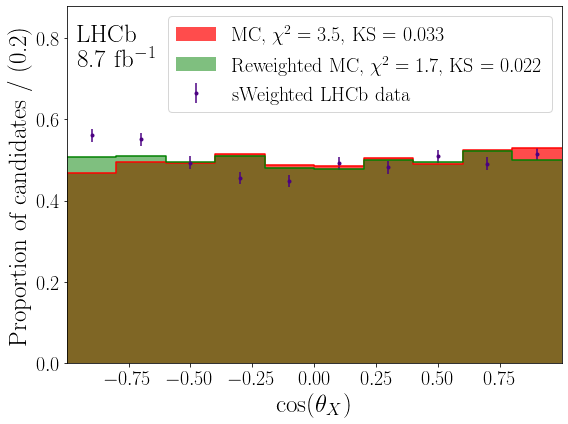

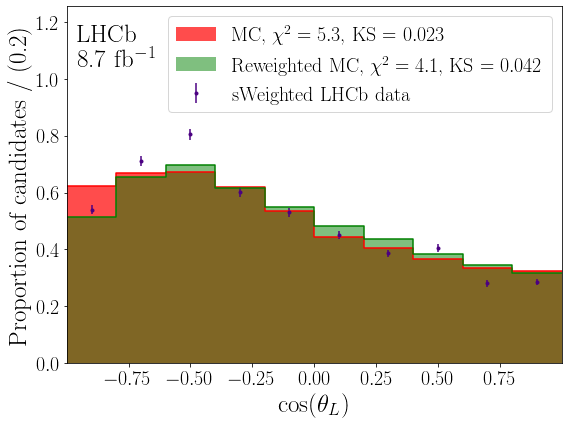

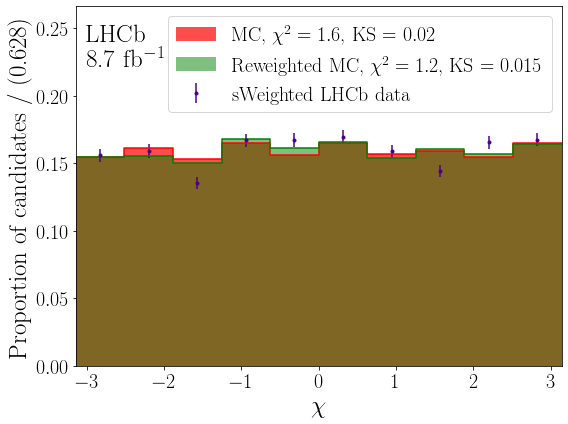

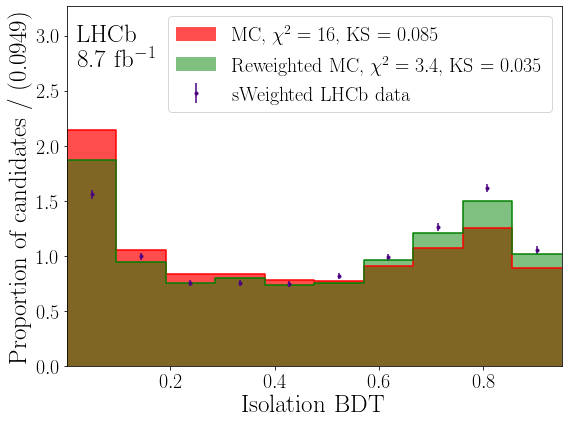

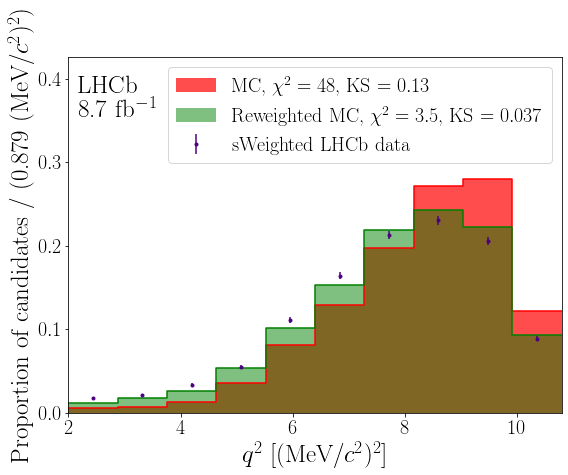

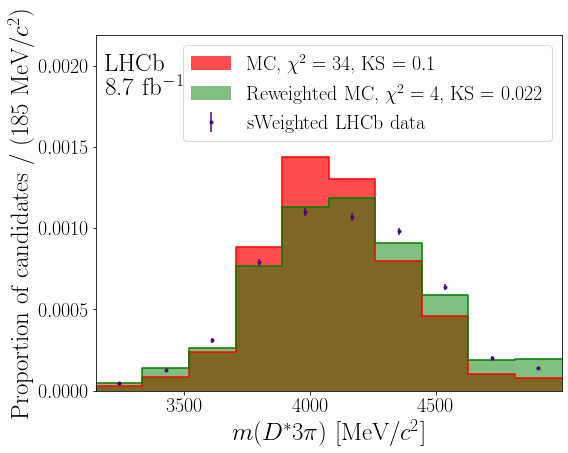

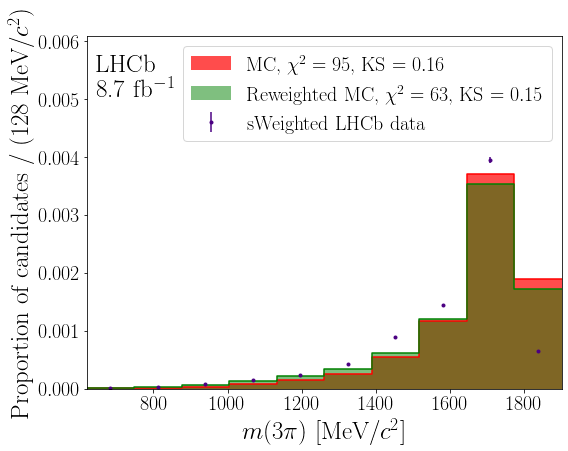

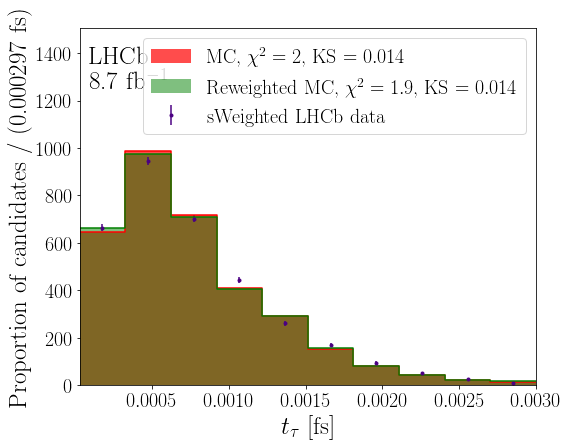

In [33]:
for column in plot_columns:
    if column in column_ranges:
        low, high = column_ranges[column]
    else:
        low = None
        high = None

        
    chi2 = {}
    chi2['original'] = str_number_into_latex(f"{result_chi2[column]['original']:.2g}")
    chi2['reweighted_MC'] = str_number_into_latex(f"{result_chi2[column]['reweighted_MC']:.2g}")
    
    KS = {}
    KS['original'] = str_number_into_latex(f"{result_ks[column]['original']:.2g}")
    KS['reweighted_MC'] = str_number_into_latex(f"{result_ks[column]['reweighted_MC']:.2g}")
    
    fig, ax = plot_hist_auto({'MC': df['MC'], 
                              'Reweighted MC': df['MC'],
                              'sWeighted LHCb data':df['data']
                             }, 
                             column, fig_name=column,
                             labels=[
                                 ', $\\chi^2 = {}$'.format(chi2['original']) + f", KS = ${KS['original']}$",
                                 ', $\\chi^2 = {}$'.format(chi2['reweighted_MC']) + f", KS = ${KS['reweighted_MC']}$",
                                 None
                             ],
                             folder_name=f'{weight_MC_name}_vs_{data_name}', bar_mode=[True, True, False], 
                             low=low, high=high, n_bins=n_bins,
                             alpha=[0.7, 0.5, 1],
                             colors=['r', 'g', 'indigo'], 
                             weights=[None, 
                                      df['MC']['weight'],
                                      df['data']['sWeight']
                                     ],
                             pos_text_LHC={'ha': 'left'})

## Weights distribution

Figure saved in /home/correiaa/bd2dsttaunu/output/plots//BTODstDX_MC_weights/reweighting_weights


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='Reweighting weights', ylabel='Candidates / (0.0966)'>)

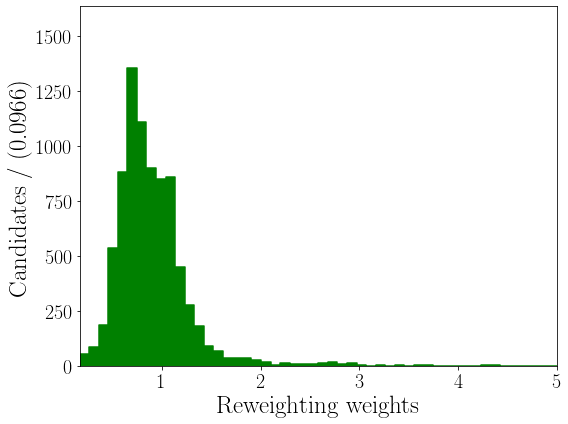

In [34]:
plot_hist_var(df['MC']['weight'], 'reweighting_weights', unit=None,
              colors='g', data_names='reweighted_MC', n_bins=50, high=5,
              latex_branch='Reweighting weights', bar_mode=True,
              fig_name='reweighting_weights', folder_name=weight_MC_name)

## Compare other reweighting

/home/correiaa/miniconda/envs/bd2dsttaunu_env/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/correiaa/miniconda/envs/bd2dsttaunu_env/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


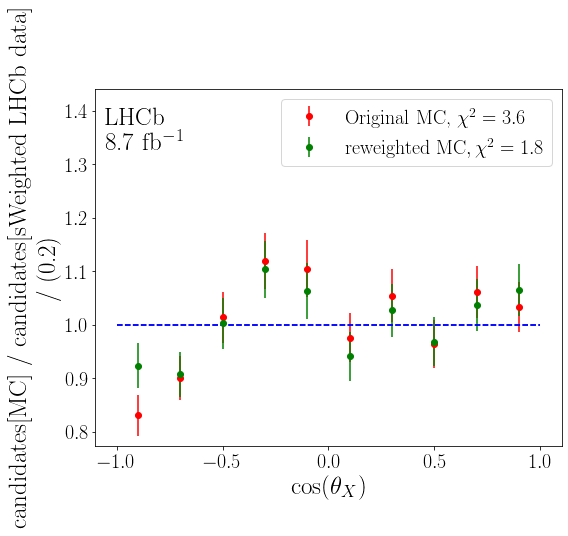

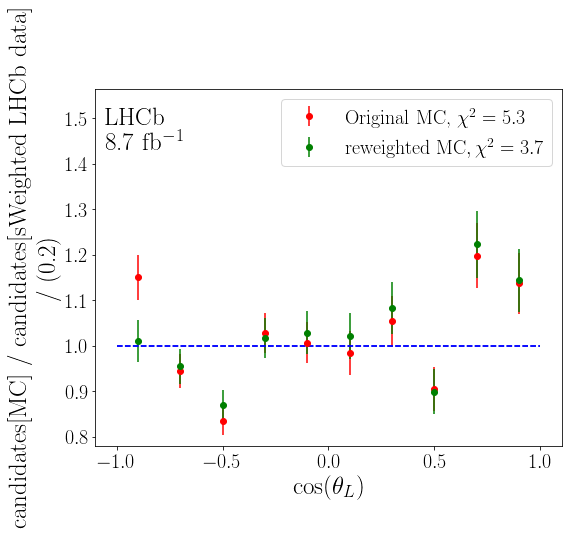

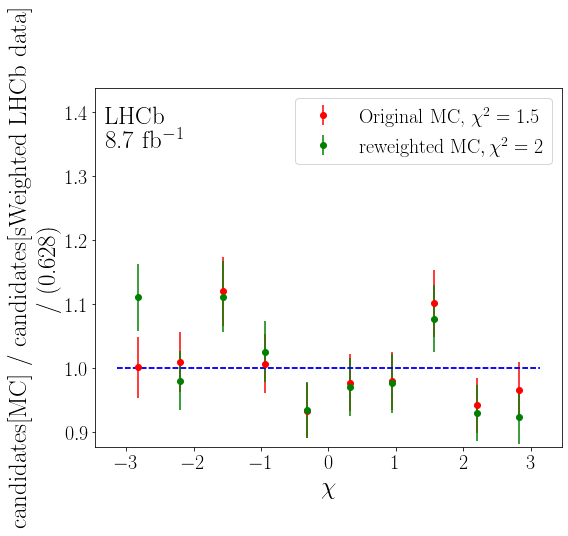

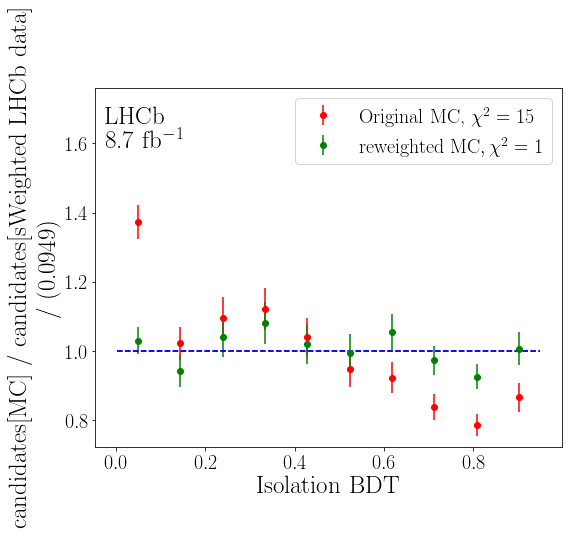

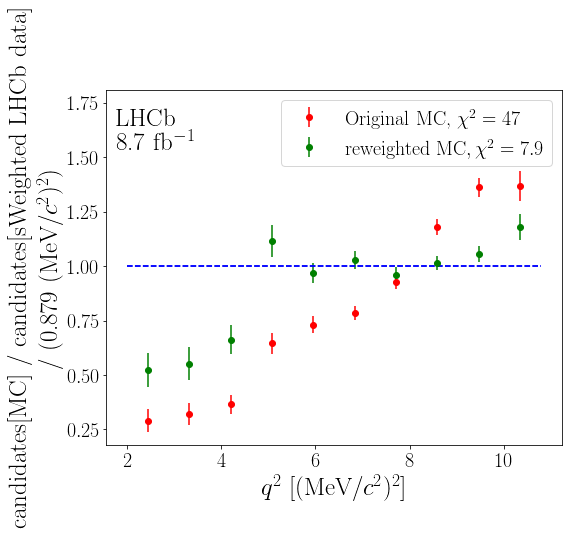

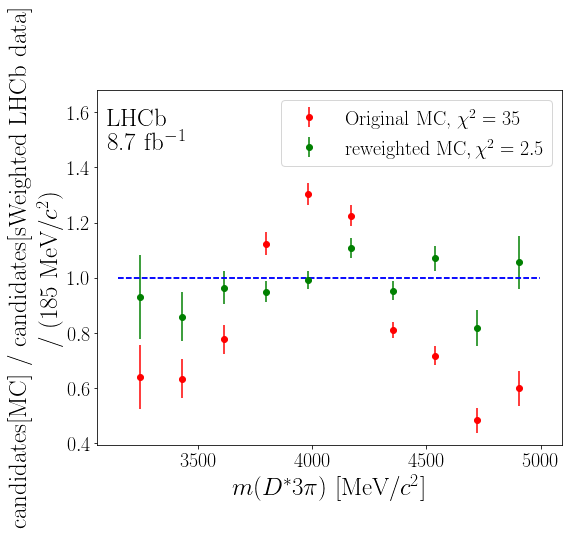

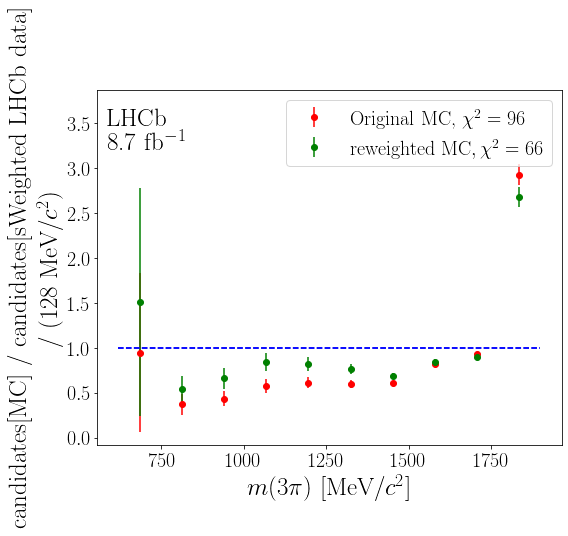

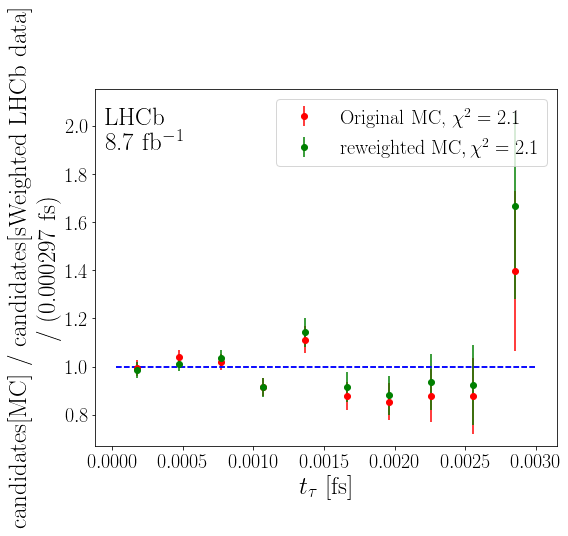

In [10]:
for column in plot_columns:
    if column in column_ranges:
        low, high = column_ranges[column]
    else:
        low = None
        high = None
    
    chi2 = {}
    chi2['original'] = str_number_into_latex(f"{result_chi2[column]['original']:.2g}")
    
    fig, ax = plot_divide_auto({'MC': df['MC'], 'sWeighted LHCb data':df['data']}, 
                               column, fig_name=column, label=f"Original MC, $\\chi^2 = {chi2['original']}$",
                               low=low, high=high, n_bins=n_bins, color='r',
                               weights=[None, df['data']['sWeight']],
                               pos_text_LHC={'ha': 'left'}, save_fig=False)

    
    chi2['reweighted_MC'] = str_number_into_latex(f"{result_chi2[column]['reweighted_MC']:.2g}")
    
       
    plot_divide_auto({'MC': df['MC'], 'sWeighted LHCb data':df['data']}, 
                     column, 
                     label='reweighted MC'+f"$, \\chi^2 = {chi2['reweighted_MC']}$",
                     color='g',
                     weights=[df['MC']['weight'], df['data']['sWeight']],
                     ax=ax,
                     low=low, high=high, n_bins=n_bins, folder_name=f'{weight_MC_name}_d_{data_name}')

    ax.legend(fontsize=20, ncol=1) 

### Some results obtained before

```python
hyperparams ={
    'n_estimators': 100, # defaut:30
    'learning_rate': 0.2, # defaut:0.2
    'max_depth': 3, # defaut
    'min_samples_leaf': 200 # defaut
}
```

```
            q2_reco  isolation_bdt  tau_life_reco  m_DstKpipi  theta_X_reco  \
original   0.108439       0.398597      35.375965    0.001045      0.036359   
basic      0.010510       0.052623      42.209354    0.000600      0.012812   
with_B0_M  0.012990       0.055588      39.061796    0.000548      0.014801   

           theta_L_reco  chi_reco  costheta_X_reco  costheta_L_reco  \
original       0.049673  0.010413         0.063870         0.072641   
basic          0.015507  0.007217         0.028175         0.022066   
with_B0_M      0.014988  0.007576         0.032106         0.021901   

           coschi_reco     tau_M      B0_M  
original      0.042141  0.000309  0.000462  
basic         0.045948  0.000197  0.000279  
with_B0_M     0.043398 -0.000216  0.000043  
```

```python
hyperparams ={
    'n_estimators': 30, # defaut:30
    'learning_rate': 0.2, # defaut:0.2
    'max_depth': 3, # defaut
    'min_samples_leaf': 200 # defaut
}
```

```
            q2_reco  isolation_bdt  tau_life_reco  m_DstKpipi  theta_X_reco  \
original   0.108439       0.398597      35.375965    0.001045      0.036359   
basic      0.012018       0.058257      44.667868    0.000616      0.013031   
with_B0_M  0.013486       0.075142      39.592194    0.000510      0.021183   

           theta_L_reco  chi_reco  costheta_X_reco  costheta_L_reco  \
original       0.049673  0.010413         0.063870         0.072641   
basic          0.019434  0.007915         0.029261         0.026215   
with_B0_M      0.025924  0.009505         0.039431         0.034830   

           coschi_reco     tau_M      B0_M  
original      0.042141  0.000309  0.000462  
basic         0.041461  0.000195  0.000277  
with_B0_M     0.047680 -0.000155  0.000059  
```
